## Flow
- Loading the dataset
- Training the model
- Validation Accuracy Check
- Tuning Parameter 

## Imports

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print("List of files",os.listdir("../input"))
import torch
import numpy as np
print("Torch Version:",torch.__version__)
# Any results you write to the current directory are saved as output.

List of files ['digit-recognizer']
Torch Version: 1.0.0


## Building our Network
Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image using MNIST data
For now our goal will be to build a neural network that can take one of these images and predict the digit in the image.First, let's try to build this network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

![](images/mnist.PNG)

In [74]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import helper
import matplotlib.pyplot as plt

### Load Dataset 
First up, we need to get our dataset.Right now we will be using MNIST dataset which is already in`torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. 

In [75]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We have the training data loaded into trainloader 

With dataloaded we make  an iterator with iter(trainloader). Later, we'll use this to loop through the dataset for training, like below:

In [76]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
#Printing the size of one image
print(images[1].numpy().squeeze().shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
(28, 28)


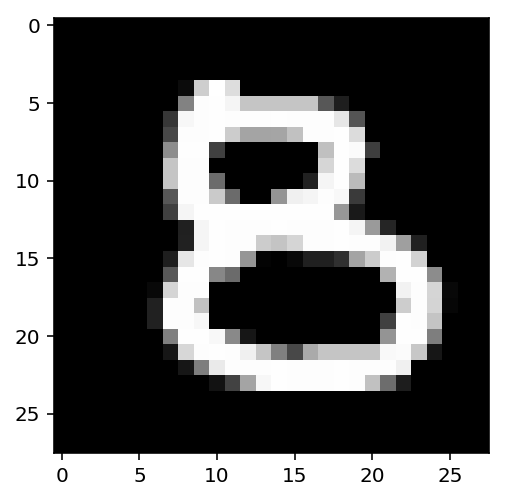

In [77]:
#Look at the image
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Now we have 10 outputs for our network. This raw output is usually called **logits or scores**.
<br>
However,We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to.


### Probability Distribution using Softmax
To calculate this probability distribution, we often use the [softmax function](https://en.wikipedia.org/wiki/Softmax_function)
$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$
What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

In [83]:
def softmax(x):
    return(torch.exp(x)/torch.sum(torch.exp(x),dim=1).view(-1,1))

In [87]:
#print(torch.exp(out[1:3])/torch.sum(torch.exp(out[1:3]),dim=1))
temp=torch.exp(out[1:3])/torch.sum(torch.exp(out[1:3]),dim=1).view(-1,1)
print(temp)

tensor([[0.0449, 0.1211, 0.0446, 0.1205, 0.0649, 0.1211, 0.1211, 0.1197, 0.1211,
         0.1210],
        [0.0498, 0.1350, 0.0497, 0.0505, 0.1350, 0.0499, 0.1350, 0.1347, 0.1264,
         0.1339]])


Voila!! We got the softmax output .One last thing to do is check whether the sum across all classes sum to 1 for understanding the predicted class

In [88]:
temp.sum(dim=1)

tensor([1., 1.])

In [89]:
probabilities = softmax(out)
# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
#print(probabilities.sum(dim=1))

torch.Size([64, 10])


## Building our Network with Pytorch

![](images/mlp_mnist.PNG)

PyTorch provides a module `nn` that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [90]:
from torch import nn

In [91]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden=nn.Linear(784,256)
        self.output=nn.Linear(256,10)
        self.sigmoid=nn.Sigmoid()
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.hidden(x)
        x=self.sigmoid(x)
        x=self.output(x)
        x=self.softmax(x)
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network once it's create at `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation a reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [92]:
model=Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

We can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.


In [93]:
import torch.nn.functional as F

In [94]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 128)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(128, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

In [95]:
model=Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and bias are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [96]:
print(model.hidden.weight,model.hidden.weight.shape)
print(model.hidden.bias,model.hidden.bias.shape)

Parameter containing:
tensor([[-0.0033, -0.0026, -0.0164,  ..., -0.0308,  0.0194,  0.0055],
        [-0.0038,  0.0220,  0.0195,  ...,  0.0263, -0.0158,  0.0255],
        [-0.0271,  0.0259, -0.0018,  ..., -0.0255, -0.0197,  0.0196],
        ...,
        [-0.0226, -0.0048, -0.0072,  ..., -0.0170,  0.0275, -0.0274],
        [-0.0028,  0.0030,  0.0137,  ..., -0.0046, -0.0090,  0.0115],
        [-0.0302,  0.0081, -0.0323,  ..., -0.0194, -0.0074,  0.0023]],
       requires_grad=True) torch.Size([128, 784])
Parameter containing:
tensor([ 0.0167,  0.0271,  0.0063, -0.0016,  0.0206, -0.0016,  0.0036, -0.0076,
         0.0105, -0.0310, -0.0025, -0.0094,  0.0347, -0.0294, -0.0061,  0.0052,
         0.0052,  0.0115,  0.0229, -0.0134, -0.0010,  0.0006, -0.0315,  0.0100,
        -0.0288,  0.0176,  0.0343,  0.0254, -0.0033,  0.0076, -0.0077, -0.0086,
         0.0209, -0.0210,  0.0286,  0.0117, -0.0188,  0.0013, -0.0105, -0.0211,
         0.0009,  0.0022, -0.0245,  0.0222, -0.0050, -0.0263, -0.0247, -

For custom initialization, we can these tensors in place.

In [97]:
# Set biases to all zeros
model.hidden.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [98]:
# sample from random normal with standard dev = 0.01
model.hidden.weight.data.normal_(std=0.01)

tensor([[-0.0148,  0.0038, -0.0110,  ..., -0.0021, -0.0139, -0.0037],
        [ 0.0014,  0.0066, -0.0124,  ..., -0.0045,  0.0032, -0.0082],
        [ 0.0003,  0.0056, -0.0123,  ..., -0.0033,  0.0010, -0.0025],
        ...,
        [ 0.0148,  0.0076,  0.0159,  ..., -0.0102, -0.0099, -0.0003],
        [ 0.0052, -0.0087, -0.0013,  ...,  0.0105, -0.0006,  0.0103],
        [-0.0060, -0.0125, -0.0029,  ..., -0.0023, -0.0020,  0.0055]])

In [99]:
netowrk=Network()

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


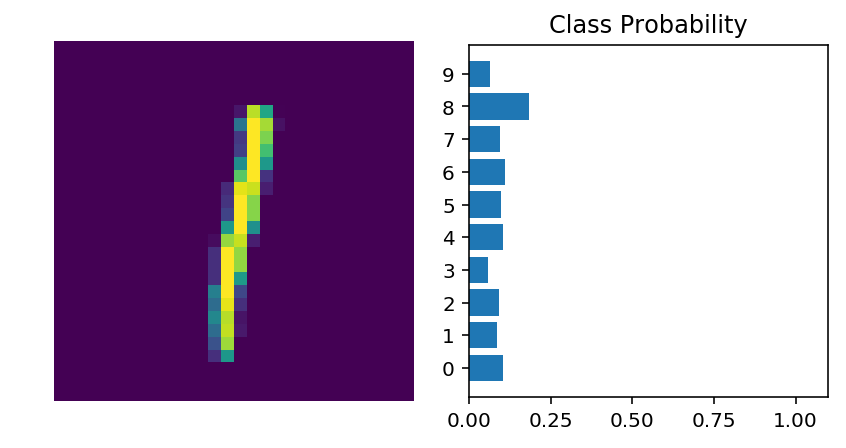

In [100]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(images.shape[0], 1, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, , all the weights are random!

## Add-on-People from the keras would love this!!!
PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential`.
Lets try to build the above network using this method:

In [101]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128]
output_size = 10

model=nn.Sequential(nn.Linear(input_size,hidden_sizes[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[0],output_size),
                    nn.ReLU(),
                    nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): ReLU()
  (4): Softmax()
)


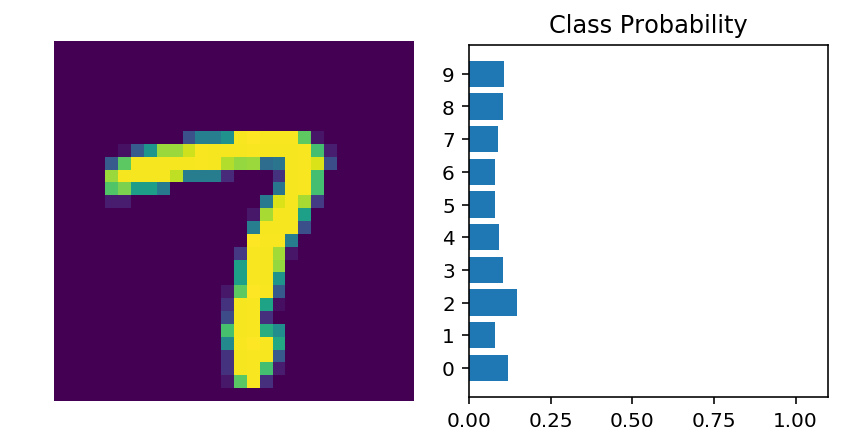

In [102]:
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

### Access Layers of the network
We can access layers  by integer 

In [103]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0072, -0.0288,  0.0269,  ..., -0.0033, -0.0193,  0.0225],
        [-0.0107,  0.0125, -0.0244,  ..., -0.0196, -0.0050, -0.0334],
        [ 0.0077, -0.0130,  0.0002,  ..., -0.0146,  0.0208,  0.0225],
        ...,
        [-0.0267, -0.0029,  0.0338,  ..., -0.0104,  0.0205,  0.0012],
        [ 0.0327, -0.0182, -0.0025,  ...,  0.0199, -0.0295, -0.0202],
        [ 0.0174,  0.0344, -0.0070,  ..., -0.0218,  0.0091,  0.0021]],
       requires_grad=True)

### Ordered Dict- Better way to create a network
We can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [104]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('hidden', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[0], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (output): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax()
)

### Access Layers using integer or name 
Now we can access layers  either by integer or name

In [105]:
print(model[0])
print(model.hidden)
print(model.hidden.weight)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)
Parameter containing:
tensor([[-0.0197, -0.0322,  0.0337,  ...,  0.0178, -0.0350, -0.0222],
        [-0.0309, -0.0018,  0.0267,  ...,  0.0142,  0.0103, -0.0044],
        [ 0.0283, -0.0074,  0.0065,  ...,  0.0166, -0.0164,  0.0073],
        ...,
        [-0.0315, -0.0024,  0.0023,  ..., -0.0095, -0.0017, -0.0276],
        [ 0.0227, -0.0242, -0.0264,  ...,  0.0262,  0.0118, -0.0069],
        [-0.0097, -0.0049, -0.0082,  ...,  0.0202, -0.0108,  0.0189]],
       requires_grad=True)


### Recollect everything 
Before we go ahead and train a neural network to accuractly predict the numbers appearing in the MNIST images,let us recollect the important modules that is necessary for any model training exercise

#### Imports

In [106]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,transforms

#### Load Data

In [107]:
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
trainset=datasets.MNIST('~/.pytorch/MNIST_data/',train=True,transform=transform,download=True)
testset=datasets.MNIST('~/.pytorch/MNIST_data/',train=False,transform=transform,download=True)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True,num_workers=0)
#will explain later
testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True,num_workers=0)

#### Build a feedforward Network

In [108]:
# TODO: Build a feed-forward network in one of the three ways mentioned above:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


#### Lets run one image through the network to check our work

In [109]:
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
print(logits.shape)

torch.Size([64, 10])


#### Define a loss function

In [110]:
criterion = nn.NLLLoss()

In [111]:
# Calculate the loss with the logits and the labels
loss=criterion(logits,labels)
print(loss)

tensor(2.2983, grad_fn=<NllLossBackward>)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.


Let's see an example to understand it better.Then again we will head back to our modelling task

In [112]:
x = torch.randn(2,2, requires_grad=True)
print(x)
y = x**2
print(y)
## grad_fn shows the function that generated this variable
print(y.grad_fn)
z = y.mean()
print(z)
print(x.grad)
z.backward()
print(x.grad)
print(x/2)

tensor([[ 1.8575, -1.5131],
        [ 0.8923, -0.2002]], requires_grad=True)
tensor([[3.4504, 2.2896],
        [0.7962, 0.0401]], grad_fn=<PowBackward0>)
tensor(1.6441, grad_fn=<MeanBackward1>)
None
tensor([[ 0.9288, -0.7566],
        [ 0.4462, -0.1001]])
tensor([[ 0.9288, -0.7566],
        [ 0.4462, -0.1001]], grad_fn=<DivBackward0>)


## Loss and Autograd together

In [113]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)


print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        ...,
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010]])


## Defining the optimizer

In [114]:
from torch import optim
optimizer=optim.Adam(model.parameters(),lr=0.1)

## Training for real

In [115]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output=model.forward(images)
        # TODO: Training pass
        
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch:{e} Training loss: {running_loss/len(trainloader)}")

Epoch:0 Training loss: 2.9852372491791814
Epoch:1 Training loss: 2.3092668727516874
Epoch:2 Training loss: 2.3100592462238727
Epoch:3 Training loss: 2.3097468924674907
Epoch:4 Training loss: 2.310148429514757


In [116]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
#helper.view_classify(img.view(1, 28, 28), ps)

## Inference and Validation

The goal of validation is to measure the model's performance on data that isn't part of the training set. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are precision and recall and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

### Inference on a batch of images
Let us try to do this for a batch of images.Before that we will make some changes in our architecture

In [117]:
images, labels = next(iter(testloader))
images.shape,labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [118]:
images, labels = next(iter(testloader))
img = images.view(images.shape[0], 784)
# Get the class probabilities
ps = torch.exp(model(img))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [119]:
top_prob,top_class=ps.topk(1,dim=1)
top_prob.shape,top_class.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [120]:
top_class.view(64)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [121]:
import pandas as pd
pd.DataFrame({"Predicted":top_class.view(top_class.shape[0]),"Actual":labels})

,Predicted,Actual
0,1,7
1,1,0
2,1,4
3,1,4
4,1,4
5,1,5
6,1,3
7,1,3
8,1,3
9,1,3


In [122]:
equals=top_class == labels.view(*top_class.shape)
accuracy=torch.mean(equals.type(torch.FloatTensor))
accuracy.item()

0.046875

In [123]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
model=Network()
optimizer=optim.Adam(model.parameters(),lr=0.01)
criterion=nn.NLLLoss()

In [124]:
epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in trainloader:
        optimizer.zero_grad()
        #images=images.view(images.shape[0],-1)
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in testloader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))    

Epoch: 1/10..  Training Loss: 0.845..  Test Loss: 0.423..  Test Accuracy: 0.873
Epoch: 2/10..  Training Loss: 0.638..  Test Loss: 0.385..  Test Accuracy: 0.899
Epoch: 3/10..  Training Loss: 0.659..  Test Loss: 0.413..  Test Accuracy: 0.888
Epoch: 4/10..  Training Loss: 0.643..  Test Loss: 0.419..  Test Accuracy: 0.900
Epoch: 5/10..  Training Loss: 0.669..  Test Loss: 0.467..  Test Accuracy: 0.877
Epoch: 6/10..  Training Loss: 0.666..  Test Loss: 0.398..  Test Accuracy: 0.901
Epoch: 7/10..  Training Loss: 0.687..  Test Loss: 0.425..  Test Accuracy: 0.896
Epoch: 8/10..  Training Loss: 0.679..  Test Loss: 0.610..  Test Accuracy: 0.836
Epoch: 9/10..  Training Loss: 0.723..  Test Loss: 0.507..  Test Accuracy: 0.867
Epoch: 10/10..  Training Loss: 0.715..  Test Loss: 0.441..  Test Accuracy: 0.888


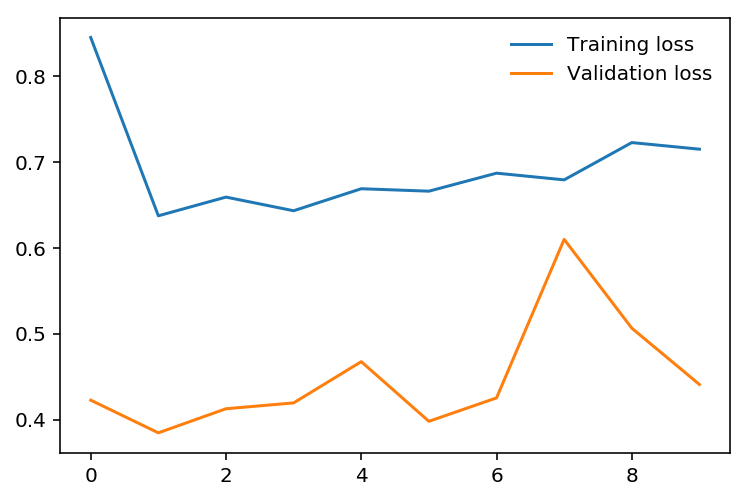

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference time

In [126]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
top_prob,top_class=ps.topk(1,dim=1)
top_class.item(),labels[0]

(3, tensor(3))

The parameters for PyTorch networks are stored in a model's state_dict
 Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers.

In [127]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([256, 784])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([128, 256])
fc2.bias 	 torch.Size([128])
fc3.weight 	 torch.Size([64, 128])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([10, 64])
fc4.bias 	 torch.Size([10])


In [128]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {140436269992120: {'step': 9380, 'exp_avg': tensor([[-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        ...,
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45],
        [-5.6052e-45, -5.6052e-45, -5.6052e-45,  ..., -5.6052e-45,
         -5.6052e-45, -5.6052e-45]]), 'exp_avg_sq': tensor([[9.7820e-15, 9.7820e-15, 9.7820e-15,  ..., 9.7820e-15, 9.7820e-15,
         9.7820e-15],
        [5.1729e-14, 5.1729e-14, 5.1729e-14,  ..., 5.1729e-14, 5.1729e-14,
         5.1729e-14],
        [2.4329e-14, 2.4329e-14, 2.4329e-14,  ..., 2.4329e-14, 2.4329e-14,
        

# Kaggle- Multilayered Perceptron (MLP) implemention on MNIST dataset
Untill now we were using the MNIST dataset that is available in torchvision.dataset.Let us now load the dataset from Kaggle repo and train our model

In [129]:
import os
from pathlib import Path
import torch
from torch.utils.data import TensorDataset ,DataLoader
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
PATH=Path("../input/digit-recognizer")
print(os.listdir("../input/digit-recognizer"))

['test.csv', 'train.csv', 'sample_submission.csv']


## Load Data 

In [130]:
train=pd.read_csv(PATH/'train.csv')
test=pd.read_csv(PATH/'test.csv')
train.shape,test.shape

((42000, 785), (28000, 784))

## Extracting Input and Target Variable

In [131]:
x=train.drop("label",axis=1)
y=np.array(train['label'])
x.shape,y.shape

((42000, 784), (42000,))

## Normalization 

In [132]:
#x_train=x/255

## Train Test Split

In [133]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

## Train Test in Pytorch

In [134]:
'''
# create feature and targets tensor for train set.
torch_X_train = torch.from_numpy(x_train.values).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(x_test.values).type(torch.FloatTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)
'''

'\n# create feature and targets tensor for train set.\ntorch_X_train = torch.from_numpy(x_train.values).type(torch.FloatTensor)\ntorch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)\n\n# create feature and targets tensor for test set.\ntorch_X_test = torch.from_numpy(x_test.values).type(torch.FloatTensor)\ntorch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)\n\n# Pytorch train and test sets\ntrain = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)\ntest = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)\n'

In [135]:
'''
BATCH_SIZE=64
# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)
'''

'\nBATCH_SIZE=64\n# data loader\ntrain_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)\ntest_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)\n'

## Train -Test Split -Pytorch

In [136]:
torch_X_train = torch.from_numpy(x.values).type(torch.FloatTensor)/255
torch_y_train = torch.from_numpy(y).type(torch.LongTensor)
myDataset = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
valid_no  = int(0.2 * len(myDataset))
# so divide the data into trainset and testset
trainSet,testSet = torch.utils.data.random_split(myDataset,(len(myDataset)-valid_no,valid_no))
print(f"len of trainSet {len(trainSet)} , len of testSet {len(testSet)}")
batch_size=64
train_loader  = DataLoader(trainSet , batch_size=batch_size ,shuffle=True) 
test_loader  = DataLoader(testSet , batch_size=batch_size ,shuffle=True)

len of trainSet 33600 , len of testSet 8400


trainData = torch.from_numpy(x_train.values)
trainLabel=torch.from_numpy(y_train)
testData = torch.from_numpy(x_test.values)
testLabel = torch.from_numpy(y_test)
trainData, testData = trainData.type(torch.FloatTensor), testData.type(torch.LongTensor)
trainLabel, testLabel = trainLabel.type(torch.FloatTensor), testLabel.type(torch.LongTensor)
trainData.shape,testData.shape
trainData = trainData.unsqueeze_(dim=1)
testData = testData.unsqueeze_(dim=1)
trainData.shape,testData.shape
#transforms =transforms.Compose(transforms.ToTensor())
train_dataset = TensorDataset(trainData,trainLabel)
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)

test_dataset = TensorDataset(testData,testLabel)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

## Network

In [285]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 20)
#         self.fc2 = nn.Linear(25, 15)
#         self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(20, 10)
        
        
#         self.fc1 = nn.Linear(784, 256)
#         self.fc2 = nn.Linear(256, 128)
#         #self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(128, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.leaky_relu(self.fc1(x)))
#         x = self.dropout(F.leaky_relu(self.fc2(x)))
#         x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
model=Network()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion=nn.NLLLoss()

## Train 

In [286]:
epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/10..  Training Loss: 1.813..  Test Loss: 1.185..  Test Accuracy: 0.782
Epoch: 2/10..  Training Loss: 1.032..  Test Loss: 0.706..  Test Accuracy: 0.847
Epoch: 3/10..  Training Loss: 0.783..  Test Loss: 0.555..  Test Accuracy: 0.869
Epoch: 4/10..  Training Loss: 0.677..  Test Loss: 0.482..  Test Accuracy: 0.881
Epoch: 5/10..  Training Loss: 0.610..  Test Loss: 0.436..  Test Accuracy: 0.886
Epoch: 6/10..  Training Loss: 0.577..  Test Loss: 0.409..  Test Accuracy: 0.892
Epoch: 7/10..  Training Loss: 0.541..  Test Loss: 0.387..  Test Accuracy: 0.898
Epoch: 8/10..  Training Loss: 0.519..  Test Loss: 0.370..  Test Accuracy: 0.900
Epoch: 9/10..  Training Loss: 0.502..  Test Loss: 0.355..  Test Accuracy: 0.902
Epoch: 10/10..  Training Loss: 0.484..  Test Loss: 0.344..  Test Accuracy: 0.905


In [287]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15910

## Save our model

In [140]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc4.weight', 'fc4.bias'])


In [141]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Load our model

In [142]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc4.weight', 'fc4.bias'])


In [143]:
model.load_state_dict(state_dict)

In [144]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [256,128,64],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Load Test Data

In [145]:
test_images = pd.read_csv("../input/digit-recognizer/test.csv")
test_image = test_images.loc[:,test_images.columns != "label"].values
test_dataset = torch.from_numpy(test_image).type(torch.FloatTensor)/255
print(test_dataset.shape)
#test_dataset = torch.utils.data.TensorDataset(test_dataset)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

torch.Size([28000, 784])


In [146]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.numpy().tolist()

## Check the results

In [147]:
predictions = np.array(results).flatten()
print(predictions[:5])
print(predictions.shape)

[2 0 9 9 3]
(28000,)


## Submit for Scoring

In [148]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("my_submissions.csv", index=False, header=True)

# Reference 

[Introduction to Pytorch-Udacity](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/intro-to-pytorch)